# Gradient Boosting Descision Trees on Donors Choose Data

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()


from collections import Counter

ModuleNotFoundError: No module named 'gensim'

In [2]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)

for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975, 

<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [3]:
import pandas
data = pandas.read_csv('preprocessed_data.csv',nrows = 50000)

In [4]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [5]:
data.describe(include = 'all')

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
count,50000,50000,50000,50000.000000,50000.00000,50000,50000,50000,50000.000000
unique,51,5,4,NaN,NaN,45,357,49765,NaN
top,ca,mrs,grades_prek_2,NaN,NaN,literacy_language,literacy,our students come diverse backgrounds blue col...,NaN
freq,7342,26757,20671,NaN,NaN,10642,4131,8,NaN
mean,NaN,NaN,NaN,9.392960,0.83986,NaN,NaN,NaN,313.384560
std,NaN,NaN,NaN,23.927948,0.36674,NaN,NaN,NaN,372.916859
min,NaN,NaN,NaN,0.000000,0.00000,NaN,NaN,NaN,0.690000
25%,NaN,NaN,NaN,0.000000,1.00000,NaN,NaN,NaN,107.060000
50%,NaN,NaN,NaN,2.000000,1.00000,NaN,NaN,NaN,228.805000
75%,NaN,NaN,NaN,7.000000,1.00000,NaN,NaN,NaN,399.990000


In [6]:
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [7]:
# adding the sentiment scores for the essays
from tqdm import tqdm
# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

SID = SentimentIntensityAnalyzer()

#http://www.nltk.org/howto/sentiment.html
    
neg = [] ;pos = []; neu = [] ; comp= []
for i in tqdm(data['essay']):
    neg.append(SID.polarity_scores(i)['neg'])
    pos.append(SID.polarity_scores(i)['neu'])
    neu.append(SID.polarity_scores(i)['pos'])
    comp.append(SID.polarity_scores(i)['compound'])



100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [10:39<00:00, 78.18it/s]


In [8]:
data['negative'] = neg
data['positive'] = pos
data['neutral'] = neu
data['compound'] = comp  


In [9]:
# to separate the labels & the features
Y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,negative,positive,neutral,compound
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.783,0.205,0.9867


In [10]:
print("The total no of data points = ",X.shape[0])
print("No of features available = ",X.shape[1])

The total no of data points =  50000
No of features available =  12


In [11]:
y_value_counts = data['project_is_approved'].value_counts()
print("Number of projects that are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects that are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")


Number of projects that are approved for funding  41993 , ( 83.986 %)
Number of projects that are not approved for funding  8007 , ( 16.014 %)


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.33, stratify = Y)


In [13]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(33500, 12) (33500,)
(16500, 12) (16500,)


<h2> 2.) Make Data Model Ready: Featurization</h2>

## 2.1) Essay

### 2.1.1) Encoding essay TFiDF

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(min_df=10)
vectorizer_tfidf.fit(X_train['essay'].values)

X_train_essay_tfidf = vectorizer_tfidf.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer_tfidf.transform(X_test['essay'].values)


print(X_train_essay_tfidf.shape)
print(X_test_essay_tfidf.shape)
print("="*100)


(33500, 10348)
(16500, 10348)


### 2.1.2) Encoding essay TFiDF W2V

In [15]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [16]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [17]:
len(tfidf_words)

35193

In [18]:
# average Word2Vec
# compute average word2vec for each review in the training data.
train_tfidf_w2v_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_essays.append(vector)

train_tfidf_w2v_essayar = np.array(train_tfidf_w2v_essays) 

print(len(train_tfidf_w2v_essays))
print(len(train_tfidf_w2v_essays[0]))


100%|███████████████████████████████████████████████████████████████████████████| 33500/33500 [00:58<00:00, 569.92it/s]


33500
300


In [19]:
train_tfidf_w2v_essayar.shape

(33500, 300)

In [20]:
# average Word2Vec
# compute average word2vec for each review in the test data.
test_tfidf_w2v_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_essays.append(vector)
    
test_tfidf_w2v_essayar = np.array(test_tfidf_w2v_essays) 
print(len(test_tfidf_w2v_essays))
print(len(test_tfidf_w2v_essays[0]))

100%|███████████████████████████████████████████████████████████████████████████| 16500/16500 [00:29<00:00, 561.35it/s]

16500
300


In [21]:
test_tfidf_w2v_essayar.shape

(16500, 300)

## 2.2) Response coding for categorical features

In [22]:
# a function defined to get the response coding for each feature

def response_coding(data, ytrain, feature):

    
    xtrain = X_train
    unique_cat_labels = xtrain[feature].unique() # to get the unique feature in train data
    data_cats = data[feature].unique() #  to get the unique feature in data being encoded
    dictionary = dict()
    for i in tqdm(range(len(data_cats))):
        # if - else condition created for new features in test or cv data
        if data_cats[i] in unique_cat_labels:
        
            total_count = xtrain.loc[:,feature][(xtrain[feature] == unique_cat_labels[i])].count()  ##https://stackoverflow.com/questions/66122577/response-coding-for-categorical-data
            p_0 = xtrain.loc[:, feature][((xtrain[feature] == unique_cat_labels[i]) & (ytrain==0))].count()
            p_1 = xtrain.loc[:, feature][((xtrain[feature] == unique_cat_labels[i]) & (ytrain==1))].count()

            dictionary[data_cats[i]] = [p_1/total_count, p_0/total_count]
        else :
            
            dictionary[data_cats[i]] = [0.5,0.5] # giving equal probability for unseen data in train data
        
        row = []
        row.append(data_cats[i])
        
        row.append(p_1/total_count)
        row.append(p_0/total_count)
        
    return dictionary


In [23]:
# a function defined to get the response coding values for each data point in dataset for the particular feature
def response (data,ytrain,feature):
    probs = response_coding(data, ytrain, feature)
    
    p = []
    for i in tqdm(data[feature]):
        p.append(probs[i])
    arr = np.array(p)
    
    return arr

### 2.2.1) School State

In [24]:
school_state_train = response(X_train,Y_train,'school_state')
school_state_test =  response(X_test,Y_train,'school_state')

print("After response coding")
print(school_state_train.shape)
print(school_state_test.shape)

100%|███████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 2742352.83it/s]

After response coding
(33500, 2)
(16500, 2)


### 2.2.2) Teacher Prefix

In [25]:
teacher_prefix_train = response(X_train,Y_train,'teacher_prefix')
teacher_prefix_test = response(X_test,Y_train,'teacher_prefix')

print("After response coding")
print(teacher_prefix_train.shape)
print(teacher_prefix_test.shape)

100%|███████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 1838190.02it/s]

After response coding
(33500, 2)
(16500, 2)


### 2.2.3) Project Grade Category

In [26]:
project_grade_category_train = response(X_train,Y_train,'project_grade_category')
project_grade_category_test = response(X_test,Y_train,'project_grade_category')

print("After response coding")
print(project_grade_category_train.shape)
print(project_grade_category_test.shape)

100%|███████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 2757431.51it/s]


After response coding
(33500, 2)
(16500, 2)


### 2.2.4) Subject Category

In [27]:
clean_categories_train = response(X_train,Y_train,'clean_categories')
clean_categories_test = response(X_test,Y_train,'clean_categories')

print("After response coding")
print(clean_categories_train.shape)
print(clean_categories_test.shape)

100%|███████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 2350987.40it/s]

After response coding
(33500, 2)
(16500, 2)


### 2.2.5) Subject sub-category

In [28]:
clean_subcategories_train = response(X_train,Y_train,'clean_subcategories')
clean_subcategories_test = response(X_test,Y_train,'clean_subcategories')

print("After response coding")
print(clean_categories_train.shape)
print(clean_categories_test.shape)

100%|███████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 2742461.50it/s]

After response coding
(33500, 2)
(16500, 2)


### 2.3) Numerical Features

<h3> 2.3.1) encoding numerical features: Price</h3>

In [29]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(1,-1)) #as our array price has a single feature

#norm means the normalized features

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1)) 
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

#reshaping after normalization ,for horizontally stacking the data
X_train_price_norm = X_train_price_norm.reshape(-1,1)
X_test_price_norm = X_test_price_norm.reshape(-1,1)



print("After vectorizations")
print(X_train_price_norm.shape)
print(X_test_price_norm.shape)
print("="*100)

After vectorizations
(33500, 1)
(16500, 1)


In [30]:
X_train_price_norm[1]

array([0.00426378])

<h3> 2.3.2) encoding numerical features: number_of_previously_posted_projects</h3>

In [31]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) #as our array price has a single feature

X_train_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)) 
X_test_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

#reshaping after normalization ,for horizontally stacking the data

X_train_teacher_number_of_previously_posted_projects_norm = X_train_teacher_number_of_previously_posted_projects_norm.reshape(-1,1)
X_test_teacher_number_of_previously_posted_projects_norm = X_test_teacher_number_of_previously_posted_projects_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_teacher_number_of_previously_posted_projects_norm.shape)
print(X_test_teacher_number_of_previously_posted_projects_norm.shape)
print("="*100)

After vectorizations
(33500, 1)
(16500, 1)


In [32]:
X_train_teacher_number_of_previously_posted_projects_norm[3]

array([0.])

<h3> 2.3.3) Encoding numerical features: sentiment(negative)</h3>

In [33]:
normalizer = Normalizer()
normalizer.fit(X_train['negative'].values.reshape(-1,1)) 


senti_neg_train = normalizer.transform(X_train['negative'].values.reshape(1, -1))

senti_neg_test = normalizer.transform(X_test['negative'].values.reshape(1, -1))


#reshaping after normalization ,for horizontally stacking the data
senti_neg_train = senti_neg_train.reshape(-1,1)
senti_neg_test = senti_neg_test.reshape(-1,1)


print('After normalization')
print(senti_neg_train.shape)
print(senti_neg_test.shape)


After normalization
(33500, 1)
(16500, 1)


<h3> 2.3.4) Encoding numerical features: sentiment(positive)</h3>

In [34]:
normalizer = Normalizer()
normalizer.fit(X_train['positive'].values.reshape(-1,1)) 


senti_pos_train = normalizer.transform(X_train['positive'].values.reshape(1, -1))

senti_pos_test = normalizer.transform(X_test['positive'].values.reshape(1, -1))


#reshaping after normalization ,for horizontally stacking the data
senti_pos_train = senti_pos_train.reshape(-1,1)
senti_pos_test = senti_pos_test.reshape(-1,1)


print('After normalization')
print(senti_pos_train.shape)
print(senti_pos_test.shape)


After normalization
(33500, 1)
(16500, 1)


<h3> 2.3.5) Encoding numerical features: sentiment(neutral)</h3>

In [35]:
normalizer = Normalizer()
normalizer.fit(X_train['neutral'].values.reshape(-1,1)) 


senti_neut_train = normalizer.transform(X_train['neutral'].values.reshape(1, -1))

senti_neut_test = normalizer.transform(X_test['neutral'].values.reshape(1, -1))


#reshaping after normalization ,for horizontally stacking the data
senti_neut_train = senti_neut_train.reshape(-1,1)
senti_neut_test = senti_neut_test.reshape(-1,1)


print('After normalization')
print(senti_neut_train.shape)
print(senti_neut_test.shape)


After normalization
(33500, 1)
(16500, 1)


In [36]:
#the compound scores are already normalized 

senti_comp_train = np.array(X_train['compound']).reshape(-1,1)
senti_comp_test = np.array(X_test['compound']).reshape(-1,1)

print(senti_comp_train.shape)
print(senti_comp_test.shape)


(33500, 1)
(16500, 1)


# 3

## Set 1: categorical, numerical features(response coding) + essay (TFIDF) + Sentiment scores(essay)

### 3.1) Stacking all the featurized features together for Set -1

In [37]:
from scipy.sparse import hstack

In [38]:
X_train_S1  = hstack((X_train_essay_tfidf,school_state_train,teacher_prefix_train,teacher_prefix_train,clean_categories_train,clean_subcategories_train,X_train_price_norm,X_train_teacher_number_of_previously_posted_projects_norm,senti_neg_train,senti_pos_train,senti_neut_train,senti_comp_train)).tocsr()
X_test_S1  = hstack((X_test_essay_tfidf,school_state_test,teacher_prefix_test,teacher_prefix_test,clean_categories_test,clean_subcategories_test,X_test_price_norm,X_test_teacher_number_of_previously_posted_projects_norm,senti_neg_test,senti_pos_test,senti_neut_test,senti_comp_test)).tocsr()

print("Final Data matrix - SET A -> tfidf essay & response coded ")
print(X_train_S1.shape, Y_train.shape)
print(X_test_S1.shape, Y_test.shape)
print("="*100)

Final Data matrix - SET A -> tfidf essay & response coded 
(33500, 10364) (33500,)
(16500, 10364) (16500,)


## Set 2: categorical, numerical features(response coding)  + essay (TFIDF W2V) + Sentiment scores(essay)

### 3.2) Stacking all the featurized features together for Set -2

In [39]:
from scipy.sparse import coo_matrix
#converting the tfidf w2v array of train & test data to a sparse matrix for stacking

tr_tfidf_w2v = coo_matrix(train_tfidf_w2v_essayar)
te_tfidf_w2v = coo_matrix(test_tfidf_w2v_essayar)


In [40]:
X_train_S2  = hstack((tr_tfidf_w2v,school_state_train,teacher_prefix_train,teacher_prefix_train,clean_categories_train,clean_subcategories_train,X_train_price_norm,X_train_teacher_number_of_previously_posted_projects_norm,senti_neg_train,senti_pos_train,senti_neut_train,senti_comp_train)).tocsr()
X_test_S2  = hstack((te_tfidf_w2v,school_state_test,teacher_prefix_test,teacher_prefix_test,clean_categories_test,clean_subcategories_test,X_test_price_norm,X_test_teacher_number_of_previously_posted_projects_norm,senti_neg_test,senti_pos_test,senti_neut_test,senti_comp_test)).tocsr()

print("Final Data matrix - SET A -> tfidf W2V essay & response coded ")
print(X_train_S2.shape, Y_train.shape)
print(X_test_S2.shape, Y_test.shape)
print("="*100)

Final Data matrix - SET A -> tfidf W2V essay & response coded 
(33500, 316) (33500,)
(16500, 316) (16500,)


<h2> 4 ) Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

## 4.1) Apply GBDT Classifier on Set -1

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [43]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


## 4.1.1) Hyperparameter Tuning 

In [68]:
%%time

from sklearn.model_selection import GridSearchCV
params={'n_estimators': [1, 5, 10, 50, 100, 500],'max_depth':[10, 50, 100, 500]}

GBDT_1 = LGBMClassifier(class_weight='balanced')

CV = GridSearchCV(GBDT_1,params,cv=3,scoring='roc_auc',n_jobs= -1,return_train_score=True)

CV.fit(X_train_S1,Y_train)

Wall time: 11min 43s


GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt',
                                      class_weight='balanced',
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [10, 50, 100, 

In [69]:
print('Best score: ',CV.best_score_)
print('k value with best score: ',CV.best_params_)
print('='*75)
print('Train AUC scores')
print(CV.cv_results_['mean_train_score'])
print('CV AUC scores')
print(CV.cv_results_['mean_test_score'])

Best score:  0.7310208921320216
k value with best score:  {'max_depth': 50, 'n_estimators': 50}
Train AUC scores
[0.68918771 0.7431735  0.77479437 0.89646369 0.94822393 0.99973893
 0.68999632 0.7438851  0.77477992 0.89743319 0.95537007 0.99995815
 0.68999632 0.7438851  0.77477992 0.89743319 0.95537007 0.99995815
 0.68999632 0.7438851  0.77477992 0.89743319 0.95537007 0.99995815]
CV AUC scores
[0.64775076 0.6860084  0.69980443 0.7286476  0.72747287 0.71247257
 0.6513231  0.68693332 0.69819603 0.73102089 0.72931875 0.70895856
 0.6513231  0.68693332 0.69819603 0.73102089 0.72931875 0.70895856
 0.6513231  0.68693332 0.69819603 0.73102089 0.72931875 0.70895856]


In [70]:
params_S1 = CV.best_params_

In [48]:
print('training is done ')

training is done 


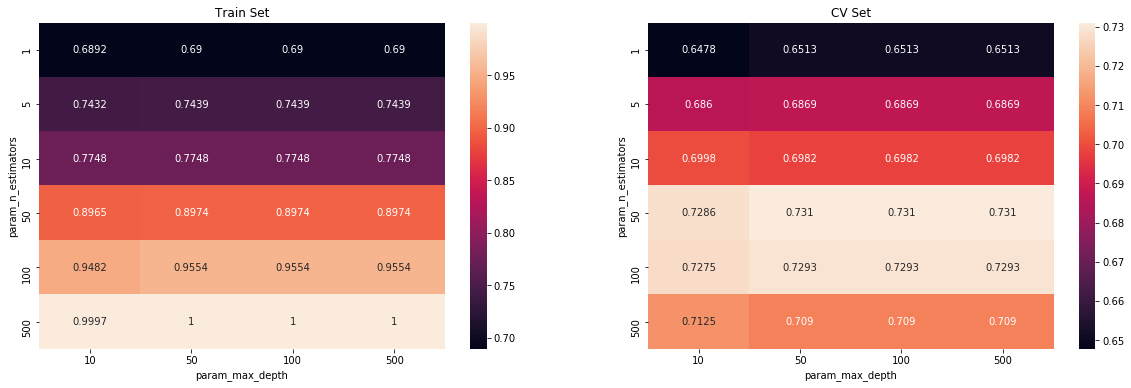

In [50]:
max_scores = pd.DataFrame(CV.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(max_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

plt.show()

## 4.1.2)Training using the best hyperparameters

In [51]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

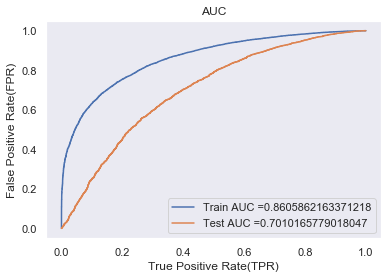

In [88]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from lightgbm import LGBMClassifier

classifier = LGBMClassifier(n_estimators=50,max_depth=50,class_weight='balanced',n_jobs=-1)

classifier.fit(X_train_S1, Y_train)
#classifier_viz.fit(X_train1, y_train)

y_train_pred = batch_predict(classifier,X_train_S1)
y_test_pred = batch_predict(classifier,X_test_S1)
#y_test_pred = batch_predict(classifier_viz,X_test1)

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)
train_auc_S1 = auc(train_fpr, train_tpr)
test_auc_S1 = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## 4.1.3) Confusion Matrix For Train & Test Data

In [54]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    global predictions1
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions1 = predictions
    return predictions

the maximum value of tpr*(1-fpr) 0.604240472187501 for threshold 0.477
the maximum value of tpr*(1-fpr) 0.42642809751203103 for threshold 0.517


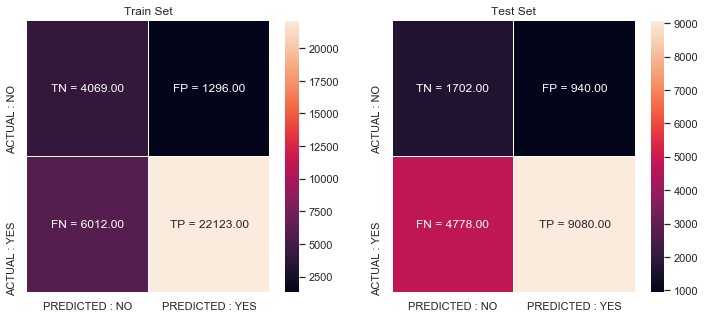

In [55]:
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()

con_m_train = confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
con_m_test = confusion_matrix(Y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5)) 

labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')

plt.show()

## 4.2) Apply GBDT Classifier on Set - 2

## 4.2.1) Hyperparameter Tuning 

In [71]:
%%time

from sklearn.model_selection import GridSearchCV
params={'n_estimators': [1, 5, 10, 50, 100, 500],'max_depth':[10, 50, 100, 500]}

GBDT_1 = LGBMClassifier(class_weight='balanced')

CV = GridSearchCV(GBDT_1,params,cv=3,scoring='roc_auc',n_jobs= -1,return_train_score=True)

CV.fit(X_train_S2,Y_train)

Wall time: 3min 20s


GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt',
                                      class_weight='balanced',
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [10, 50, 100, 

In [72]:
print('Best score: ',CV.best_score_)
print('k value with best score: ',CV.best_params_)
print('='*75)
print('Train AUC scores')
print(CV.cv_results_['mean_train_score'])
print('CV AUC scores')
print(CV.cv_results_['mean_test_score'])

Best score:  0.706482418451411
k value with best score:  {'max_depth': 50, 'n_estimators': 100}
Train AUC scores
[0.68520879 0.75806314 0.78968396 0.90886928 0.9689914  0.99998581
 0.68520879 0.75806314 0.78972129 0.90900619 0.97113829 0.99998449
 0.68520879 0.75806314 0.78972129 0.90900619 0.97113829 0.99998449
 0.68520879 0.75806314 0.78972129 0.90900619 0.97113829 0.99998449]
CV AUC scores
[0.62331897 0.66666468 0.67830018 0.70641803 0.70484389 0.69233298
 0.62331897 0.66666468 0.67861356 0.70585425 0.70648242 0.69280714
 0.62331897 0.66666468 0.67861356 0.70585425 0.70648242 0.69280714
 0.62331897 0.66666468 0.67861356 0.70585425 0.70648242 0.69280714]


In [73]:
params_S2 = CV.best_params_
params_S2

{'max_depth': 50, 'n_estimators': 100}

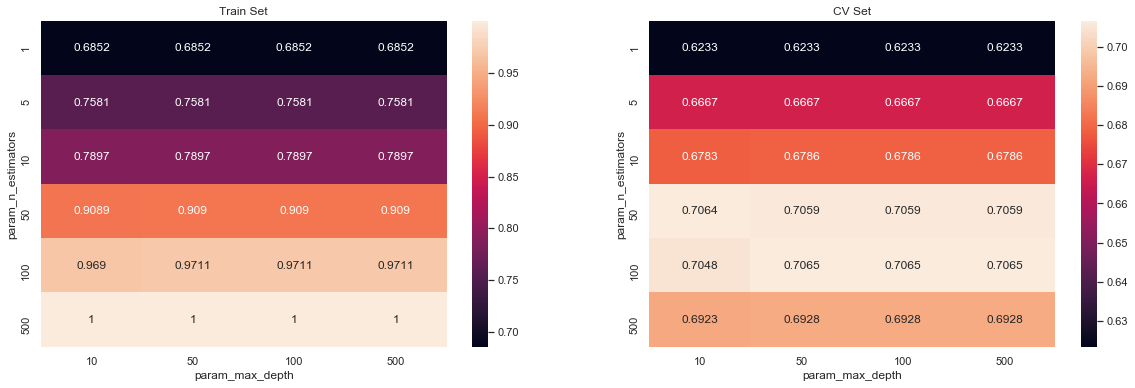

In [60]:
max_scores = pd.DataFrame(CV.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(max_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

plt.show()

## 4.2.2)Training using the best hyperparameters

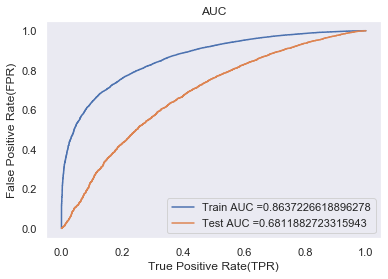

In [92]:
from sklearn.metrics import roc_curve, auc
from lightgbm import LGBMClassifier

classifier = LGBMClassifier(n_estimators=50,max_depth=100,class_weight='balanced',n_jobs=-1)

classifier.fit(X_train_S2, Y_train)
#classifier_viz.fit(X_train1, y_train)

y_train_pred = batch_predict(classifier,X_train_S2)
y_test_pred = batch_predict(classifier,X_test_S2)
#y_test_pred = batch_predict(classifier_viz,X_test1)

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)
train_auc_S2 = auc(train_fpr, train_tpr)
test_auc_S2 = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## 4.2.3) Confusion Matrix For Train & Test Data

In [62]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    global predictions1
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions1 = predictions
    return predictions

the maximum value of tpr*(1-fpr) 0.604240472187501 for threshold 0.477
the maximum value of tpr*(1-fpr) 0.42642809751203103 for threshold 0.517


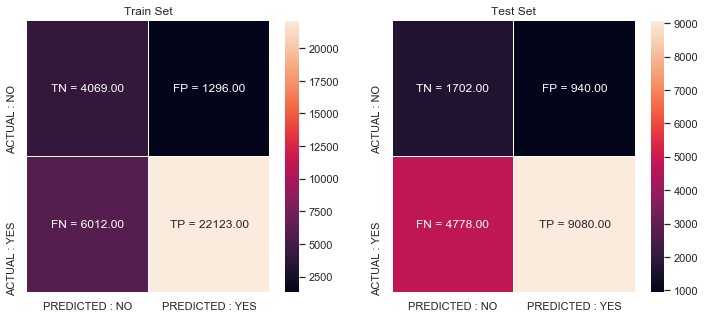

In [63]:
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()

con_m_train = confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
con_m_test = confusion_matrix(Y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5)) 

labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')

plt.show()

In [78]:
import warnings
warnings.filterwarnings('ignore')

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [93]:
# Please compare all your models using Prettytable library
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
TB = PrettyTable()

TB.field_names = ["Vectorizer", "best parameters", "AUC Train", "AUC Test"]

TB.add_row(["Response coding + TfiDF", params_S1, train_auc_S1, test_auc_S1])
TB.add_row(["Response coding + TfiDF - W2V ", params_S2, train_auc_S2, test_auc_S2])


print(TB)

+--------------------------------+----------------------------------------+--------------------+--------------------+
|           Vectorizer           |            best parameters             |     AUC Train      |      AUC Test      |
+--------------------------------+----------------------------------------+--------------------+--------------------+
|    Response coding + TfiDF     | {'max_depth': 50, 'n_estimators': 50}  | 0.8605862163371218 | 0.7010165779018047 |
| Response coding + TfiDF - W2V  | {'max_depth': 50, 'n_estimators': 100} | 0.8637226618896278 | 0.6811882723315943 |
+--------------------------------+----------------------------------------+--------------------+--------------------+


Here we see that the train AUC for tfidf & TF-iDF W2V features is nearly same but there's a difference while the Test data comes to play.
The tfidf is better than tfidfW2V by a slight margin.The GBDT also performs better than descision trees evident from our performance scores in previous assignments.

Also, here we've used LightGBM reason being, Faster training speed and higher efficiency: Light GBM use histogram based algorithm i.e it buckets continuous feature values into discrete bins which fasten the training procedure.(Src:Google)

So,eventually testing for different sets of features always backs our selection criteria for which features,featurizations to consider.

======================================================================================================================

Reference :- AAIC reference notebooks, Applied AI course